# MSR GeoLife Data Neighborhood (Home) Estimation

# Part I. Getting Data from Blob Storage

In [9]:
from azure.storage.blob import BlockBlobService
import os

In [10]:
!mkdir geolife

mkdir: cannot create directory ‘geolife’: File exists


In [11]:
local_path=os.getcwd() + "/geolife"
blob_account_name = "mldsdatahack2019diag" # fill in your blob account name
blob_account_key = "JsauBssnY92CeD3MgI2SWhkQ16JioJCRWVW8NzKtcWckI+DaNNbCmpmMAVq27GD91mhgH+oHPx+QbIKUCow5gA=="  # fill in your blob account key
mycontainer = "datahackdata2019"       # fill in the container name 
myblobname = "000/Trajectory/20090705025307.csv"        # fill in the blob name 
mydatafile = "Output"        # fill in the output file name

In [12]:
import azure
from azure.storage.blob import BlockBlobService

blob_service = BlockBlobService(account_name=blob_account_name, account_key=blob_account_key)
containers = blob_service.list_containers()
blobs = [a for a in blob_service.list_blobs("datahackdata2019")]
csv_names = [a.name for a in blobs]

In [13]:
for name in csv_names:
    if name == "BCycleAustin.csv": continue
    blob_service.get_blob_to_path("datahackdata2019", name, os.path.join(local_path, name))

In [15]:
'''
    Function to collect desired user information. See examples of usage in next few cells.
    
    Input:
       - user_list  : list of desired user ids, should be 3 digit strings
            - e.g. '000', '001', ..., '180'
       - query      : string query to perform filtering on dataframe. 
            - Should be in the form ' [COLUMN] [QUALIFIER] [VALUE] '. 
            - Look into pandas.query for examples
       - date_range : list containing two valid DATETIMES
            - Format: [start, end]
            - If either is None, then no min/max date will be applied.
       - transportation: list containing what types of transportation
            - Format: [transportation1, transportation2, ...]
            - Default is None, which takes all types (even no transportation)
       - null_transport: boolean whether or not to include rows without transportation
            - e.g. if True, then keep all rows, o/w remove these blanks
    Output:
       - df : Pandas Dataframe with desired information
            
'''
def extract_users(PATH='./geolife',
                  user_list=[],
                  query = None,
                  date_range = [None,None],
                  transportation = [None],
                  null_transport = True):
    dfs = []
    
    start = date_range[0]
    end = date_range[1]
    
    check_transportation = transportation[0] != None
    
    for user in user_list:
        df = pd.read_csv(PATH+'/'+user+'.csv')
        df.fillna('', inplace=True)
        if start is None:
            start = df.DateTime.min()
        if end is None:
            end = df.DateTime.max()
        if query is not None:
            df = df.query(query)
        if not check_transportation:
            df = df[ (df.DateTime > start) & (df.DateTime < end) ]
        else:
            df = df[ (df.DateTime > start) & (df.DateTime < end) & (df['Transportation Mode'].isin(transportation))]
        
        if not null_transport:
            df = df[ df['Transportation Mode'] != '' ]
        dfs.append(df)
        start = date_range[0]
        end = date_range[1]
    return pd.concat(dfs,ignore_index=True)

In [16]:
# Install a mapping library
!pip install folium

You are using pip version 9.0.3, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
# Library for visualizing on maps, for resources look here: 
#  https://python-visualization.github.io/folium/quickstart.html#Getting-Started
import folium

# Estimate Living Neighborhood

In this section we attempt to find possible neighborhoods for a given user. We define the living neighborhood as the area around a center location such that the person travel to-from most frequently.

The core idea is to make different guesses based on the density of known trajectory. The main procedure follows

1. Extract the anchor point for each trajectory
2. Estimate probability density function (pdf) for the set of anchor points
3. Find the maximizer of the pdf, denote it as the center of the neighborhood
4. Remove the point in the neighborhood
5. Repeat step 2-4
6. Normalize to find the confidence level for each center


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
import math

Extract all trajectories for a user.

In [74]:
df = extract_users(user_list=['010'])

/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Now we choose the "anchor point" of a trajectory. We've tried many combinations of trajectory path sampling. After trials, one can pick the start and/or end of the trajectory.

In [89]:
start_idx = df.groupby(['Trajectory'])['Days Passed'].transform(min) == df['Days Passed']
# end_idx = df.groupby(['Trajectory'])['Days Passed'].transform(max) == df['Days Passed']
idx = start_idx
# idx = end_idx
# idx = np.logical_or(start_idx, end_idx)

In [94]:
anchors = df.loc[start_idx, ['Latitude', 'Longitude']]
anchors = np.vstack([anchors['Latitude'], anchors['Longitude']]).T

We estimate the pdf of anchor point samples by kernel density estimation

$$\rho_K(y) = \sum_{i=1}^N K((y - x_i)/h)$$

where we pick Gaussian kernel in our estimation. The $h$ parameter (bandwidth) depends on the neighborhood size hyperparameter.

The Sci-kit library outputs the log probablity; we take exponential of the quantity to find probability

In [102]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(anchors)
z = np.exp(kde.score_samples(anchors))

Next we optimize for the maximizer of a peak in this pdf. We simply use gradient descent with numerical gradient to make the walk.

$$x^{(t+1)} = x^{(t)} - \eta \nabla f(x^{(t)})$$

$$\nabla f(x^{(t)}) = \left[\frac{f(x^{(t)} + \Delta x e_i) - f(x^{(t)})}{\Delta x} \right]_{i=1}^2$$

$\eta$ and $\Delta x$ are parameters set to be small enough. The anchor point $x^{(0)}$ with highest probability estimation is selected as the initial point.

In [106]:
def dfdx(f, x1, x2, eps):
    return (f(x2) - f(x1)) / eps

EPS = 1e-8
def dkde_d2(kde, x):
    d = np.zeros(2)
    for i in range(2):
        dh = np.array([0.0, 0.0])
        dh[i] = EPS
        d[i] = dfdx(kde.score, x, x+dh, EPS)
    return d

ETA = 1e-4
def find_max_kde(kde, xinit):
    x = xinit
    print('start', x, np.exp(kde.score(x)))
    for _ in range(1000):
        x = x + ETA * dkde_d2(kde, x)
    print('stop', x, np.exp(kde.score(x)))
    return x

home_xy = find_max_kde(kde, anchors[z == np.max(z)][:1])

start [[ 39.989023 116.331888]] 16.6662716235293
stop [[ 39.98810756 116.33020946]] 16.677819566592177


Now measure the distance between each anchor point and the center found in previous step. Since the data covers a large area, we measure the distance with Great Circle distance given in https://janakiev.com/blog/gps-points-distance-python/.

In [107]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + \
        np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a)) / 1000  # in kilometers

In [108]:
# dist_xy = np.sqrt(np.sum((xy - home_xy)**2, axis=1))
dist_xy = haversine(anchors.T, home_xy.T)

As a check, the foloowing plots show the found center of neighborhood is indeed closed to most point.

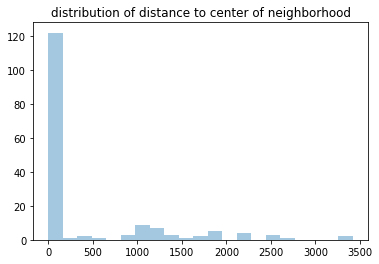

In [116]:
sns.distplot(dist_xy, kde=False)
plt.title('distribution of distance to center of neighborhood')
plt.show()

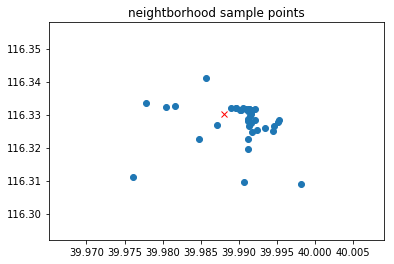

In [124]:
near_home_idx = dist_xy < 3
plt.scatter(xy[near_home_idx, 0], xy[near_home_idx, 1])
plt.plot(home_xy[:, 0], home_xy[:, 1], 'rx')
plt.title('neightborhood sample points')
plt.show()

In [123]:
def plot_df(df_t, anchor):
    m = folium.Map(
        location=anchor,
        zoom_start=14,
        tiles='Stamen Terrain'
    )

    for i in range(0,len(df_t),1):
        folium.Marker([df_t['Latitude'].values[i], df_t['Longitude'].values[i]], 'blue').add_to(m)
    folium.Marker(anchor, icon=folium.Icon(color='red')).add_to(m)
    return m
plot_df(df.loc[start_idx], home_xy[0])

This method can be turned into an iterative one by removing the point within distance and repeat steps from pdf approximation.

The confidence level is normalized via softmax to get the probability.

It is also implemented in $\texttt{home.py}$.